# Исследование

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.options.display.max_colwidth = 200

## Загрузка данных

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape

((5282, 20), (1761, 19))

In [3]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Случайный сэмпл

In [4]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3381,15,85.6,1345.55,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),1
4377,1,70.5,70.5,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
1255,66,54.8,3465.7,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,Yes,Mailed check,0
5091,43,25.1,1070.15,Female,0,No,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Electronic check,0
3774,62,23.4,1429.65,Male,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0


Информация по столбцам - null нет

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
(train.isna() | train.isnull()).sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

В столбце TotalSpent есть пропуски, заполним

In [7]:
(train.TotalSpent == ' ').sum(), (test.TotalSpent == ' ').sum()

(9, 2)

In [8]:
total_spent = pd.to_numeric(train.TotalSpent, errors='coerce')
train.TotalSpent = total_spent.fillna(0) # total_spent.mean()
total_spent = pd.to_numeric(test.TotalSpent, errors='coerce')
test.TotalSpent = total_spent.fillna(0)

## Анализ данных

### Числовые фичи

In [9]:
num_cols

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

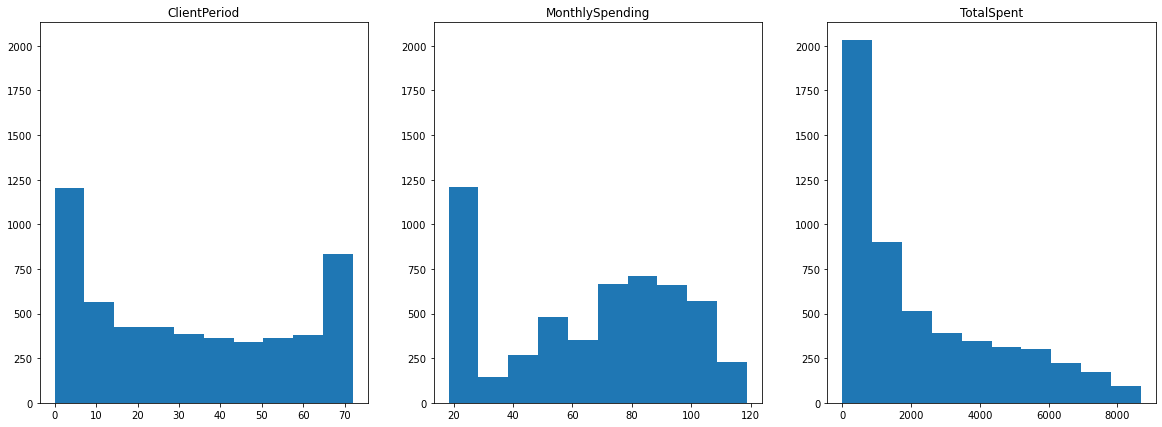

In [10]:
plt.figure(figsize=(20, 7))
ax = None
for i, column in enumerate(num_cols):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    ax.set_title(column)
    plt.hist(train[column])
plt.show()

### Категориальные фичи

In [11]:
out = list()
for column in cat_cols:
    out.append([column, train[column].nunique(), dict(train[column].value_counts())])
pd.DataFrame(out, columns=['column', 'num_uniq', 'count_uniq'])

,column,num_uniq,count_uniq
0,Sex,2,"{'Male': 2655, 'Female': 2627}"
1,IsSeniorCitizen,2,"{0: 4440, 1: 842}"
2,HasPartner,2,"{'No': 2705, 'Yes': 2577}"
3,HasChild,2,"{'No': 3676, 'Yes': 1606}"
4,HasPhoneService,2,"{'Yes': 4761, 'No': 521}"
5,HasMultiplePhoneNumbers,3,"{'No': 2511, 'Yes': 2250, 'No phone service': 521}"
6,HasInternetService,3,"{'Fiber optic': 2341, 'DSL': 1800, 'No': 1141}"
7,HasOnlineSecurityService,3,"{'No': 2612, 'Yes': 1529, 'No internet service': 1141}"
8,HasOnlineBackup,3,"{'No': 2332, 'Yes': 1809, 'No internet service': 1141}"
9,HasDeviceProtection,3,"{'No': 2317, 'Yes': 1824, 'No internet service': 1141}"


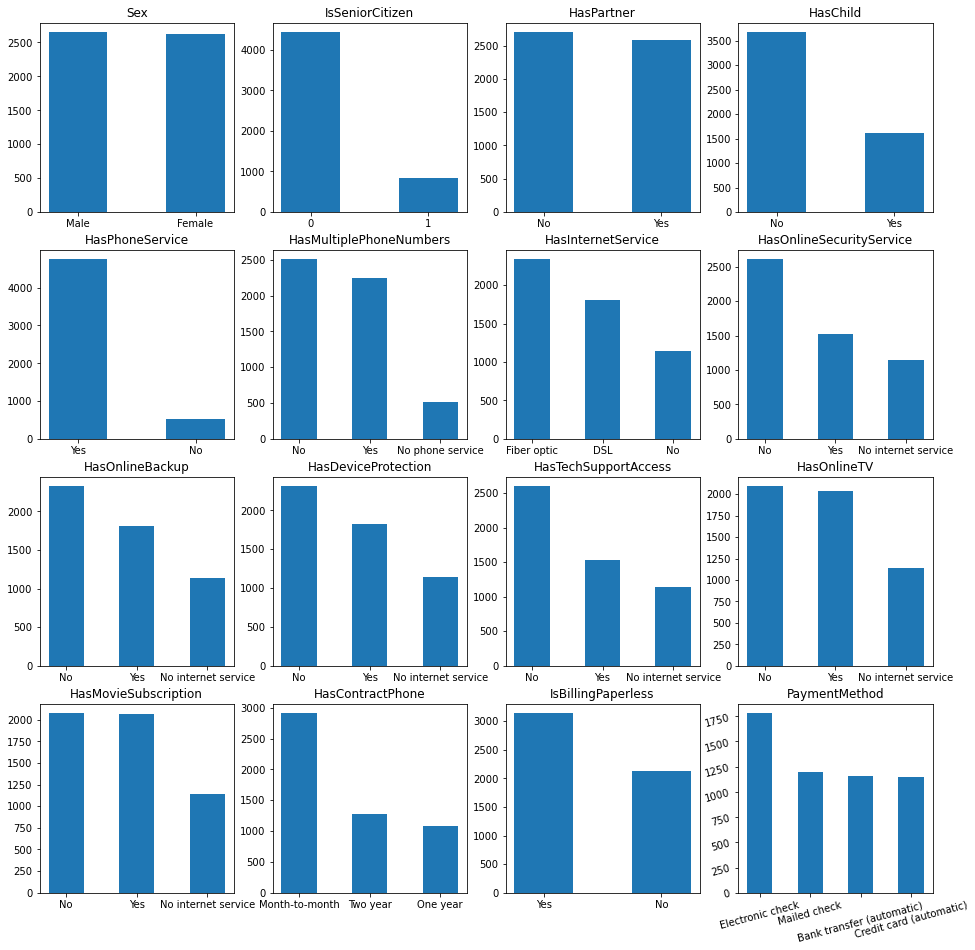

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    x = np.arange(len(labels))
    ax[i].set_title(column)
    ax[i].bar(x, values, width=0.5)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    if i == 15:
        ax[i].tick_params(labelrotation=15)

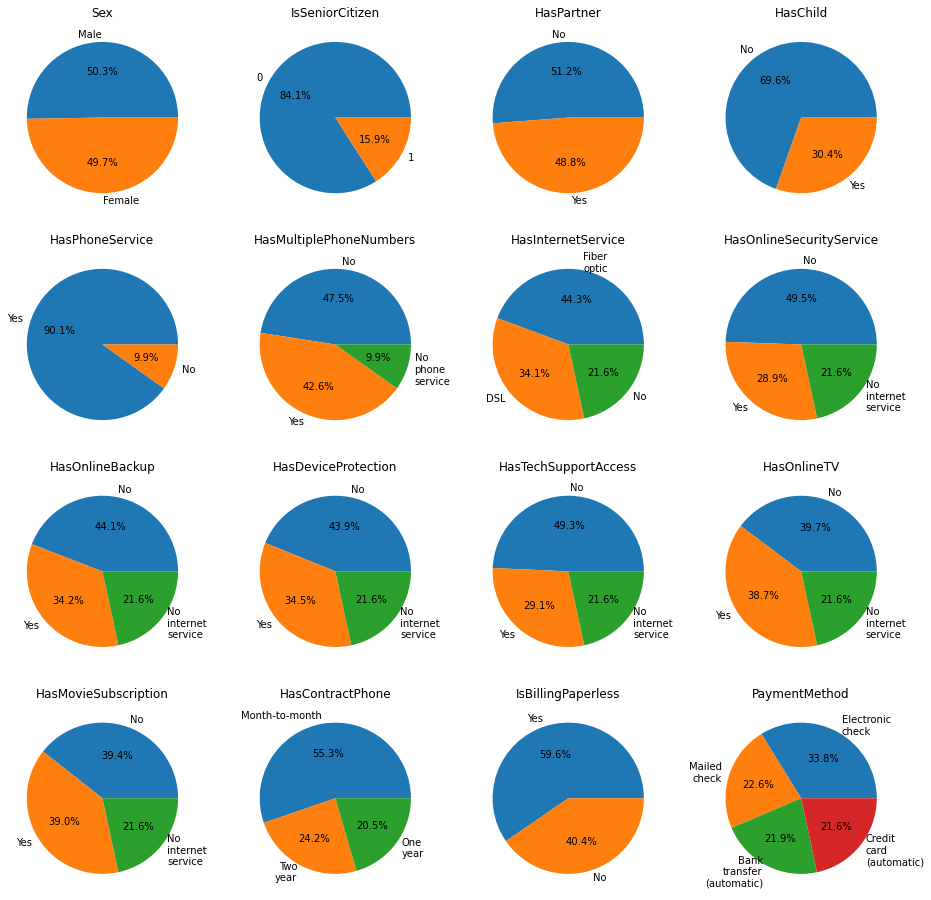

In [13]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    ax[i].set_title(column)
    ax[i].pie(values,
              labels=[str(s).replace(' ', '\n') for s in labels],
              autopct='%1.1f%%')

Несбалансированных (сильно) классов нет

## Нормирование

In [14]:
cb_train = train.copy()
cb_test = test.copy()

In [15]:
y = train[target_col]

### Кодирование категориальных признаков

#### One-hot-encoder

In [16]:
dummy_data = pd.get_dummies(train[cat_cols], drop_first=True) # drop_first=True
train = pd.concat([train[num_cols], dummy_data], axis=1)

In [17]:
train[set(train.columns) - set(feature_cols)].head(5)

,HasOnlineTV_No internet service,HasDeviceProtection_Yes,HasMultiplePhoneNumbers_No phone service,HasTechSupportAccess_No internet service,HasOnlineBackup_Yes,HasInternetService_Fiber optic,HasOnlineSecurityService_No internet service,IsBillingPaperless_Yes,HasDeviceProtection_No internet service,HasContractPhone_One year,...,HasOnlineSecurityService_Yes,HasPartner_Yes,HasMovieSubscription_Yes,PaymentMethod_Credit card (automatic),HasMovieSubscription_No internet service,Sex_Male,HasContractPhone_Two year,HasInternetService_No,HasTechSupportAccess_Yes,HasPhoneService_Yes
0,1,0,0,1,0,0,1,0,1,1,...,0,1,0,0,1,1,0,1,0,1
1,1,0,0,1,0,0,1,0,1,0,...,0,1,0,1,1,1,1,1,0,1
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,1,0,0,1,1,0,0,0,0,...,1,1,1,1,0,0,1,0,1,1


In [18]:
dummy_data = pd.get_dummies(test[cat_cols], drop_first=True) # drop_first=True
test = pd.concat([test[num_cols], dummy_data], axis=1)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, random_state=1)

### Нормирование числовых признаков

In [20]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
train[num_cols] = scaler.transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

## Обучение моделей

In [21]:
X_train

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
246,1.442176,1.435182,2.132938,0,1,0,0,1,0,1,...,0,1,0,1,1,0,0,0,1,0
3847,-0.066666,0.480628,0.037505,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
471,0.504247,1.163167,0.950690,0,0,0,0,1,0,0,...,0,1,0,1,1,0,1,0,1,0
1102,-1.126934,-0.689201,-0.921299,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
759,-1.290052,-0.490613,-0.995810,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0.422688,0.647508,0.582593,1,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0
5192,-1.290052,0.140193,-0.987512,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3980,-0.352123,1.129791,0.049448,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,1,0,0
235,-0.433682,0.458934,-0.252898,0,0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,1,0


In [22]:
models_params = {
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 30, 50, 100],
        }
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators' : [30, 50, 70, 100, 150, 200],
            'min_samples_split': [5, 10, 15, 20, 25, 30]
        }
    },
    
    'svm' : {
        'model': svm.SVC(gamma = 'auto'),
        'params': {
            'C': [1, 10, 20], 
            'kernel': ['rbf', 'linear']
        }
    },    
}

In [23]:
score_table = list()
for model_name, value in models_params.items():
    clf = GridSearchCV(
        value['model'],
        value['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=10,
    )
    clf.fit(train, y)
    print(clf.cv_results_['mean_test_score'])
    score_table.append({
        'model': model_name ,
        'best_score': clf.best_score_ ,
        'best_params': clf.best_params_,
        'best_model': clf.best_estimator_
    })

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0.83289796 0.83912777 0.84372909 0.84494343 0.8450908  0.84512692
 0.84513248 0.84512319]
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[0.82087463 0.82504572 0.82825681 0.82733178 0.82907379 0.82978218
 0.83151653 0.83338192 0.83547817 0.83527041 0.83641124 0.83589289
 0.83453186 0.83550098 0.83705844 0.83771983 0.83845186 0.83827098
 0.83844695 0.83855983 0.84013964 0.84097298 0.84043098 0.84066722
 0.83920607 0.84071649 0.84066417 0.84116651 0.8411699  0.84191206
 0.83933276 0.84128068 0.84093361 0.84167023 0.84224444 0.8422953 ]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[0.81858568 0.83433244 0.80341798 0.83441522 0.79962139 0.83448743]


In [24]:
pd.DataFrame(score_table, columns=['model', 'best_score', 'best_params'])

,model,best_score,best_params
0,logistic_regression,0.845132,{'C': 50}
1,random_forest,0.842295,"{'min_samples_split': 30, 'n_estimators': 200}"
2,svm,0.834487,"{'C': 20, 'kernel': 'linear'}"


In [25]:
y_pred = score_table[0]['best_model'].predict_proba(test)[:,-1]

### Градиентный бустинг

#### xgboost

In [26]:
import xgboost

In [27]:
params = {
#     'booster': ['gbtree'],
#     'n_estimators' : [8, 10, 12],
#     'eta': [0.07, 0.1, 0.12],
#     'max_depth': [7, 10, 12],
#     'min_child_weight': [6, 7, 8, 9],
#     'gamma': [0.03, 0.05, 0.07],
#     'colsample_bytree': [0.25, 0.3, 0.35],
    'booster': ['gblinear'],
    'n_estimators': [10000],
    'updater': ['shotgun']
}
clf = GridSearchCV(
    xgboost.XGBClassifier(),
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=10
)
clf.fit(train, y)
print(clf.cv_results_['mean_test_score'])
print(clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/envs/my_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:09:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.84511578]
{'booster': 'gblinear', 'n_estimators': 10000, 'updater': 'shotgun'}


In [28]:
max(clf.cv_results_['mean_test_score'])

0.8451157828108873

Результаты предыдущих испытаний

In [29]:
pd.options.display.max_colwidth = 200
pd.DataFrame([
    [{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.07, 'gamma': 0.07, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 10}, 0.8409537799837079],
    [{'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 10}, 0.8414464698372527],
    [{'colsample_bytree': 0.3, 'eta': 0.1, 'gamma': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 10}, 0.842736281878973],
    [{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.12, 'gamma': 0.07, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 10}, 0.8436879028707965],
    [{'booster': 'gblinear', 'eta': 0.15, 'lambda': 0, 'n_estimators': 500, 'updater': 'coord_descent'}, 0.844827631927552],
    [{'booster': 'gblinear', 'n_estimators': 500}, 0.8448524559481427],
    [{'booster': 'gblinear', 'n_estimators': 1000, 'updater': 'shotgun'}, 0.8449470472449274]
], columns=['best_params', 'mean_test_score'])

,best_params,mean_test_score
0,"{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.07, 'gamma': 0.07, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 10}",0.840954
1,"{'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 10}",0.841446
2,"{'colsample_bytree': 0.3, 'eta': 0.1, 'gamma': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 10}",0.842736
3,"{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.12, 'gamma': 0.07, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 10}",0.843688
4,"{'booster': 'gblinear', 'eta': 0.15, 'lambda': 0, 'n_estimators': 500, 'updater': 'coord_descent'}",0.844828
5,"{'booster': 'gblinear', 'n_estimators': 500}",0.844852
6,"{'booster': 'gblinear', 'n_estimators': 1000, 'updater': 'shotgun'}",0.844947


In [30]:
y_pred = clf.best_estimator_.predict_proba(test)[:,-1]

#### catboost

In [31]:
import catboost

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(
    cb_train[feature_cols], y, train_size=0.8, random_state=1, stratify=y
)

In [33]:
boost_model = catboost.CatBoostClassifier(n_estimators=500, cat_features=cat_cols)
boost_model.fit(X_train, y_train)
y_train_pred = boost_model.predict_proba(X_train)[:, 1]
y_valid_pred = boost_model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_valid, y_valid_pred)

Learning rate set to 0.035992
0:	learn: 0.6690134	total: 70.3ms	remaining: 35.1s
1:	learn: 0.6479169	total: 83.6ms	remaining: 20.8s
2:	learn: 0.6296667	total: 101ms	remaining: 16.7s
3:	learn: 0.6121389	total: 108ms	remaining: 13.4s
4:	learn: 0.5952603	total: 117ms	remaining: 11.6s
5:	learn: 0.5818628	total: 121ms	remaining: 10s
6:	learn: 0.5704104	total: 128ms	remaining: 9s
7:	learn: 0.5579946	total: 135ms	remaining: 8.29s
8:	learn: 0.5473440	total: 143ms	remaining: 7.78s
9:	learn: 0.5364404	total: 151ms	remaining: 7.38s
10:	learn: 0.5266759	total: 159ms	remaining: 7.06s
11:	learn: 0.5175718	total: 167ms	remaining: 6.78s
12:	learn: 0.5081390	total: 175ms	remaining: 6.54s
13:	learn: 0.5008260	total: 182ms	remaining: 6.32s
14:	learn: 0.4939126	total: 190ms	remaining: 6.15s
15:	learn: 0.4877612	total: 198ms	remaining: 5.98s
16:	learn: 0.4822673	total: 207ms	remaining: 5.87s
17:	learn: 0.4787208	total: 213ms	remaining: 5.71s
18:	learn: 0.4740540	total: 222ms	remaining: 5.63s
19:	learn: 0.4

179:	learn: 0.3831946	total: 1.41s	remaining: 2.5s
180:	learn: 0.3830856	total: 1.42s	remaining: 2.5s
181:	learn: 0.3829196	total: 1.43s	remaining: 2.49s
182:	learn: 0.3828940	total: 1.44s	remaining: 2.49s
183:	learn: 0.3826334	total: 1.45s	remaining: 2.48s
184:	learn: 0.3822512	total: 1.45s	remaining: 2.48s
185:	learn: 0.3821944	total: 1.46s	remaining: 2.47s
186:	learn: 0.3818422	total: 1.47s	remaining: 2.47s
187:	learn: 0.3817389	total: 1.48s	remaining: 2.46s
188:	learn: 0.3816104	total: 1.49s	remaining: 2.46s
189:	learn: 0.3814812	total: 1.5s	remaining: 2.45s
190:	learn: 0.3813274	total: 1.51s	remaining: 2.44s
191:	learn: 0.3810858	total: 1.52s	remaining: 2.44s
192:	learn: 0.3809818	total: 1.53s	remaining: 2.43s
193:	learn: 0.3807227	total: 1.53s	remaining: 2.42s
194:	learn: 0.3806684	total: 1.54s	remaining: 2.41s
195:	learn: 0.3801734	total: 1.55s	remaining: 2.41s
196:	learn: 0.3798553	total: 1.56s	remaining: 2.4s
197:	learn: 0.3796904	total: 1.58s	remaining: 2.41s
198:	learn: 0.37

345:	learn: 0.3551464	total: 2.82s	remaining: 1.25s
346:	learn: 0.3548722	total: 2.83s	remaining: 1.25s
347:	learn: 0.3547887	total: 2.84s	remaining: 1.24s
348:	learn: 0.3547553	total: 2.85s	remaining: 1.23s
349:	learn: 0.3546352	total: 2.85s	remaining: 1.22s
350:	learn: 0.3543266	total: 2.86s	remaining: 1.22s
351:	learn: 0.3543030	total: 2.87s	remaining: 1.21s
352:	learn: 0.3540396	total: 2.88s	remaining: 1.2s
353:	learn: 0.3539471	total: 2.89s	remaining: 1.19s
354:	learn: 0.3537619	total: 2.9s	remaining: 1.18s
355:	learn: 0.3536904	total: 2.91s	remaining: 1.18s
356:	learn: 0.3536196	total: 2.91s	remaining: 1.17s
357:	learn: 0.3535442	total: 2.92s	remaining: 1.16s
358:	learn: 0.3532991	total: 2.93s	remaining: 1.15s
359:	learn: 0.3532408	total: 2.94s	remaining: 1.14s
360:	learn: 0.3531606	total: 2.95s	remaining: 1.14s
361:	learn: 0.3527657	total: 2.96s	remaining: 1.13s
362:	learn: 0.3526896	total: 2.97s	remaining: 1.12s
363:	learn: 0.3523796	total: 2.97s	remaining: 1.11s
364:	learn: 0.

(0.890740663661742, 0.8542110525528893)

In [34]:
# boost_model.fit(cb_train[feature_cols], y)

Пробуем подобрать

In [35]:
params = {
#     "learning_rate":[0.025, 0.03, 0.04],
#     "min_data_in_leaf":[88, 90, 92],
#     "depth": [3, 4, 5],
#     "iterations":[187, 190, 193]
# iter0
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_data_in_leaf': [10, 50, 100],
#     'depth': [3, 5, 10],
#     'iterations': [100, 200, 300]
# iter1
#     'learning_rate': [0.07, 0.1, 0.15],
#     'min_data_in_leaf': [5, 10, 20],
#     'depth': [4, 5, 7],
#     'iterations': [50, 100, 150]
# iter2
#     'learning_rate': [0.05, 0.1, 0.15],
#     'min_data_in_leaf': [10, 15, 20],
#     'depth': [4, 5, 6, 7],
#     'iterations': [100, 120, 150]
# iter3
    'learning_rate': [0.07, 0.1, 0.12],
    'min_data_in_leaf': [10, 12, 14],
    'depth': [5],
    'iterations': [110, 120, 130]
# iter4
#     'learning_rate': [0.08, 0.1, 0.12],
#     'min_data_in_leaf': [8, 9, 10, 12, 14],
#     'depth': [4, 5, 6],
#     'iterations': [100, 105, 110, 120, 130]

}
boost_model = catboost.CatBoostClassifier(cat_features=cat_cols, random_seed=1, verbose=False)
result = boost_model.grid_search(params, X_train, y_train)


bestTest = 0.4292435478
bestIteration = 108

0:	loss: 0.4292435	best: 0.4292435 (0)	total: 543ms	remaining: 14.1s

bestTest = 0.4266548856
bestIteration = 101

1:	loss: 0.4266549	best: 0.4266549 (1)	total: 1.07s	remaining: 13.4s

bestTest = 0.4276486347
bestIteration = 57

2:	loss: 0.4276486	best: 0.4266549 (1)	total: 1.78s	remaining: 14.3s

bestTest = 0.4292254869
bestIteration = 119

3:	loss: 0.4292255	best: 0.4266549 (1)	total: 2.51s	remaining: 14.4s

bestTest = 0.4266548856
bestIteration = 101

4:	loss: 0.4266549	best: 0.4266549 (1)	total: 3.05s	remaining: 13.4s

bestTest = 0.4276486347
bestIteration = 57

5:	loss: 0.4276486	best: 0.4266549 (1)	total: 3.61s	remaining: 12.6s

bestTest = 0.4289140853
bestIteration = 122

6:	loss: 0.4289141	best: 0.4266549 (1)	total: 4.21s	remaining: 12s

bestTest = 0.4266548856
bestIteration = 101

7:	loss: 0.4266549	best: 0.4266549 (1)	total: 4.8s	remaining: 11.4s

bestTest = 0.4276486347
bestIteration = 57

8:	loss: 0.4276486	best: 0.4266549 (1)	t

In [36]:
pd.DataFrame([[
    roc_auc_score(y_train, boost_model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_valid, boost_model.predict_proba(X_valid)[:, 1]),
    result['params'],
]])

,0,1,2
0,0.859223,0.856096,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 110, 'learning_rate': 0.1}"


Некоторые старые результаты

In [37]:
pd.DataFrame([
    [0.859125, 0.855956, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 100, 'learning_rate': 0.1}],
    [0.85573, 0.855295, {'min_data_in_leaf': 5, 'depth': 4, 'iterations': 150, 'learning_rate': 0.07}],
    [0.859285, 0.856213, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 120, 'learning_rate': 0.1}],
    [0.859223, 0.856096, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 110, 'learning_rate': 0.1}],
    [0.859723, 0.856381, {'min_data_in_leaf': 8, 'depth': 6, 'iterations': 105, 'learning_rate': 0.08}],
])

,0,1,2
0,0.859125,0.855956,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 100, 'learning_rate': 0.1}"
1,0.855730,0.855295,"{'min_data_in_leaf': 5, 'depth': 4, 'iterations': 150, 'learning_rate': 0.07}"
2,0.859285,0.856213,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 120, 'learning_rate': 0.1}"
3,0.859223,0.856096,"{'min_data_in_leaf': 10, 'depth': 5, 'iterations': 110, 'learning_rate': 0.1}"
4,0.859723,0.856381,"{'min_data_in_leaf': 8, 'depth': 6, 'iterations': 105, 'learning_rate': 0.08}"


# Предсказания

#### catboost

In [38]:
y_pred = boost_model.predict_proba(cb_test)[:,-1]

In [39]:
submission = pd.read_csv('./submission.csv', index_col='Id')
submission['Churn'] = y_pred
submission.to_csv('./my_submission.csv')